# Spaceship Titanic with SVM

# Summary
* About the dataset;
* Evaluation;
* Importing libraries;
* EDA;
* Feature engineering;
* Building models;
* Results.

# About the dataset

Spaceship Titanic is a competition heavly inspired on the original Titanic shipwreck, but more sci-fi themed. The objective of this notebook is trying to find the best model that fits the evaluation metric for the problem (Accuracy), trying to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly.

## File anda Data Field Descriptions
train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

| Variable     | Description                                                               |
| ------------ | ------------------------------------------------------------------------- |
| PassengerId  | A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always. |
| HomePlanet   | The planet the passenger departed from, typically their planet of permanent residence. |
| CryoSleep    |  Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins. |
| Cabin        | The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. |
| Destination  | The planet the passenger will be debarking to. |
| Age          | The age of the passenger. |
| VIP          | Whether the passenger has paid for special VIP service during the voyage. |
| RoomService  | Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities. |
| FoodCourt    | Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities. |
| ShoppingMall | Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities. |
| Spa          | Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities. |
| VRDeck       | Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities. |
| Name         | The first and last names of the passenger. |
| Transported  | Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict. |

test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

sample_submission.csv - A submission file in the correct format.
PassengerId - Id for each passenger in the test set.
Transported - The target. For each passenger, predict either True or False.

# Evaluation
Submissions are evaluated based on their classification accuracy, the percentage of predicted labels that are correct. More about the classification metric can be found here: https://developers.google.com/machine-learning/crash-course/classification/accuracy

# Importing libraries
All the libraries used in this notebook will be imported in the cell below

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plot graphs
import seaborn as sns # better visualization for graphs
from sklearn.compose import ColumnTransformer # libraries for select columns and apply transformers
from sklearn.pipeline import Pipeline # pipeline for preprocessing
from sklearn.impute import SimpleImputer # input NaN values
from sklearn.preprocessing import OneHotEncoder # transform categorical variables in numerical
from sklearn.model_selection import train_test_split # split data into train and test set
from sklearn.metrics import accuracy_score # evaluation metric
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV # hyperparameter tunning

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# EDA
Now, I'll try to find any useful information, pattern or insight from the dataset, starting by importing it and separating categorical and numerical data

In [2]:
# importing test and train data
train_data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

In [3]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


I'll split cabin in three new columns, since it will be easier to train the model on those individual data.

In [5]:
# Splitting into three new columns
train_data[["Deck", "Cabin_num", "Side"]] = train_data["Cabin"].str.split("/", expand=True)
test_data[["Deck", "Cabin_num", "Side"]] = test_data["Cabin"].str.split("/", expand=True)

# Removing the original Cabin column
train_data = train_data.drop('Cabin', axis=1)
test_data = test_data.drop('Cabin', axis=1)

train_data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Cabin_num,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


In [6]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Cabin_num,Side
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3,S
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4,S
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0,S
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1,S
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5,S


I'll split the PassengerId as well, considering that the first 4 digits represent a group number. This might help us identify which groups have higher non-transported rates.

In [7]:
# Splitting into two new columns
train_data[["GroupId", "PsngrId"]] = train_data["PassengerId"].str.split("_", expand=True)

train_data.head()

# Convert the object column to integers
train_data['GroupId'] = train_data['GroupId'].astype(int)
train_data['PsngrId'] = train_data['PsngrId'].astype(int)
train_data['Cabin_num'] = train_data['GroupId'].astype(int)

In [8]:
train_data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'Transported', 'Deck', 'Cabin_num', 'Side', 'GroupId', 'PsngrId'],
      dtype='object')

In [9]:
cat_col = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Transported', 'Deck', 'Side']
num_col = ['GroupId', 'PsngrId', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_num']

cat_data = train_data[cat_col]
num_data = train_data[num_col]

I'll start with the categorical data, by plotting some charts and plots and try to get some useful information

In [10]:
cat_data.head()

,HomePlanet,CryoSleep,Destination,VIP,Transported,Deck,Side
0,Europa,False,TRAPPIST-1e,False,False,B,P
1,Earth,False,TRAPPIST-1e,False,True,F,S
2,Europa,False,TRAPPIST-1e,True,False,A,S
3,Europa,False,TRAPPIST-1e,False,False,A,S
4,Earth,False,TRAPPIST-1e,False,True,F,S


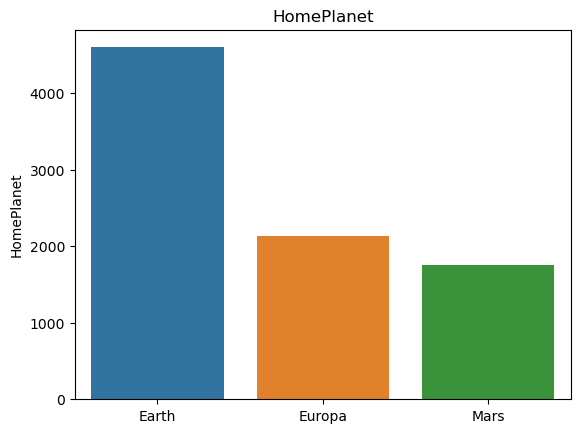

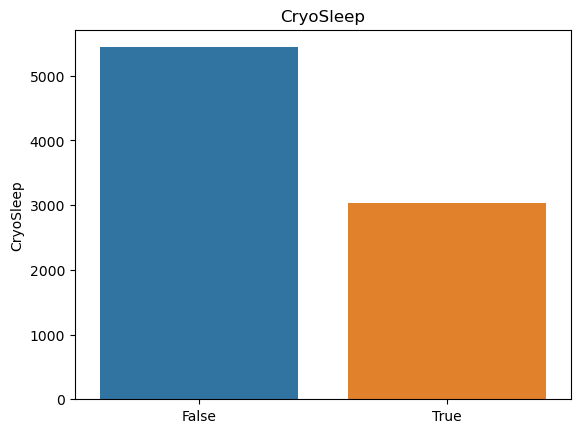

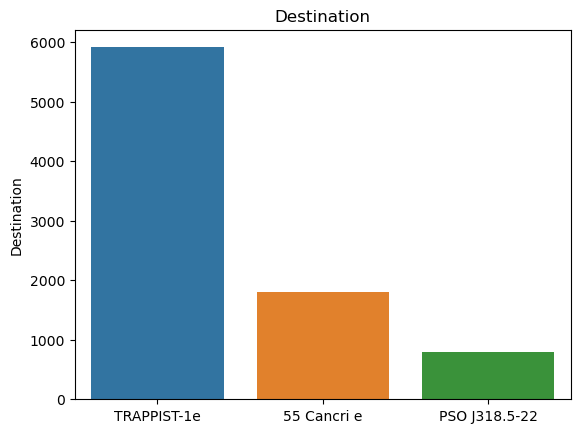

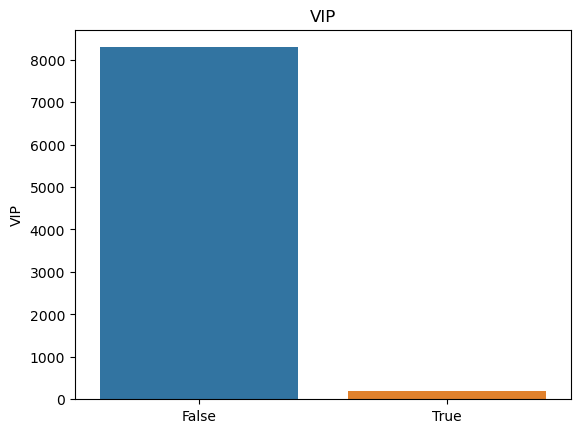

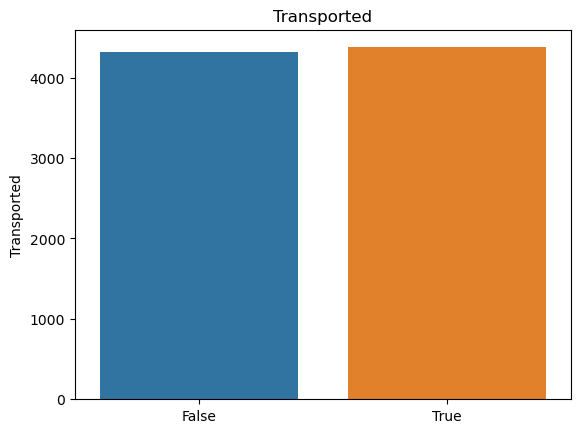

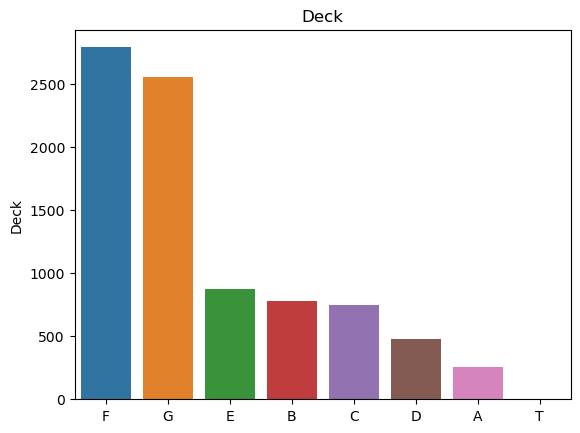

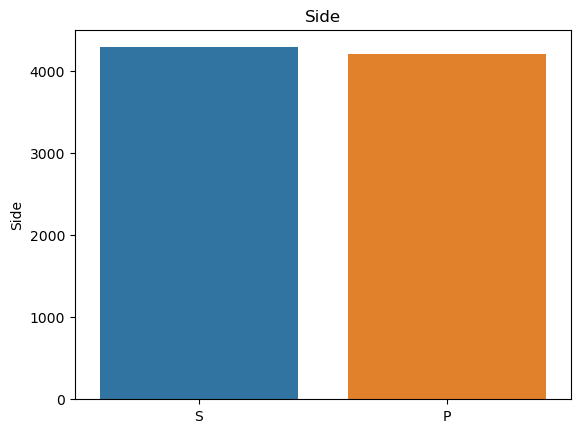

In [11]:
# Plotting barplots for the categorical data
for col_name in cat_data.columns:
    sns.barplot(x = cat_data[col_name].value_counts().index, 
                y = cat_data[col_name].value_counts())
    plt.title(col_name)
    plt.show()

Most of the people on board are from Earth, with the majority of them not in CryoSleep. They are primarily headed to TRAPPIST-1e and are not VIPs. The majority of people are assigned to Decks F and G. The number of people on the Port side and Starboard side appears to be evenly balanced. The number of people being transported seems to be evenly distributed.

In [12]:
# Comparing all those categorical variables in a pivot table
print(pd.pivot_table(train_data, index = 'Transported', columns = 'HomePlanet',
                     values = 'PassengerId', aggfunc = 'count'))
print()
print(pd.pivot_table(train_data, index = 'Transported', columns = 'CryoSleep',
                     values = 'PassengerId', aggfunc = 'count'))
print()
print(pd.pivot_table(train_data, index = 'Transported', columns = 'Destination',
                     values = 'PassengerId', aggfunc = 'count'))
print()
print(pd.pivot_table(train_data, index = 'Transported', columns = 'VIP',
                     values = 'PassengerId', aggfunc = 'count'))
print()
print(pd.pivot_table(train_data, index = 'Transported', columns = 'Deck',
                     values = 'PassengerId', aggfunc ='count'))
print()
print(pd.pivot_table(train_data, index = 'Transported', columns = 'Side',
                     values = 'PassengerId', aggfunc ='count'))
print()

HomePlanet   Earth  Europa  Mars
Transported                     
False         2651     727   839
True          1951    1404   920

CryoSleep    False  True 
Transported              
False         3650    554
True          1789   2483

Destination  55 Cancri e  PSO J318.5-22  TRAPPIST-1e
Transported                                         
False                702            395         3128
True                1098            401         2787

VIP          False  True 
Transported              
False         4093    123
True          4198     76

Deck           A    B    C    D    E     F     G  T
Transported                                        
False        129  207  239  271  563  1565  1238  4
True         127  572  508  207  313  1229  1321  1

Side            P     S
Transported            
False        2308  1908
True         1898  2380



Based on the pivot table, it is evident that a significant majority of individuals in CryoSleep have undergone transportation, while approximately 60% of VIPs have not been transported. Additionally, a substantial number of people on the B and C decks have been transported, whereas on the F deck, the proportion of transported individuals is lower compared to those who haven't been transported. This information could hold valuable insights.

Now, I'll try to gather some information about the numerical data too

In [13]:
num_data.describe()

,GroupId,PsngrId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num
count,8693.000000,8693.000000,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,4633.389624,1.517773,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,4633.389624
std,2671.028856,1.054241,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,2671.028856
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2319.000000,1.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2319.000000
50%,4630.000000,1.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4630.000000
75%,6883.000000,2.000000,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,6883.000000
max,9280.000000,8.000000,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,9280.000000


Trying to find if people have titles like Mrs. Doc. or something like that

In [14]:
print(train_data['Name'].str.contains('\.', regex=True).sum())

0


In [15]:
num_data.head()

,GroupId,PsngrId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num
0,1,1,39.0,0.0,0.0,0.0,0.0,0.0,1
1,2,1,24.0,109.0,9.0,25.0,549.0,44.0,2
2,3,1,58.0,43.0,3576.0,0.0,6715.0,49.0,3
3,3,2,33.0,0.0,1283.0,371.0,3329.0,193.0,3
4,4,1,16.0,303.0,70.0,151.0,565.0,2.0,4


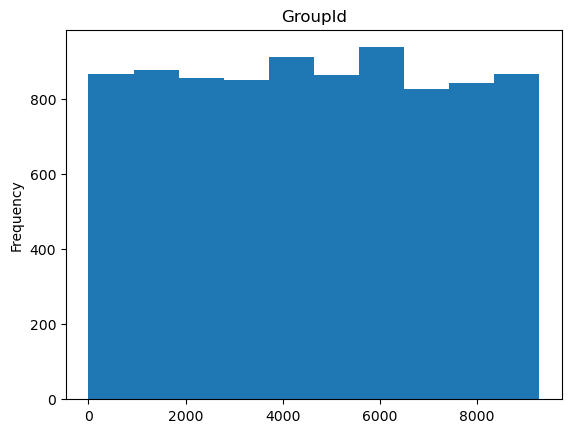

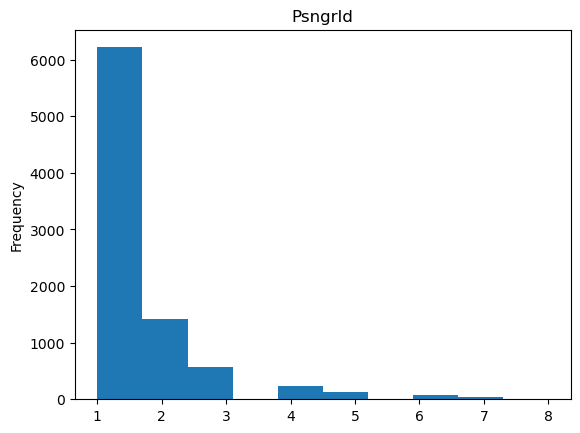

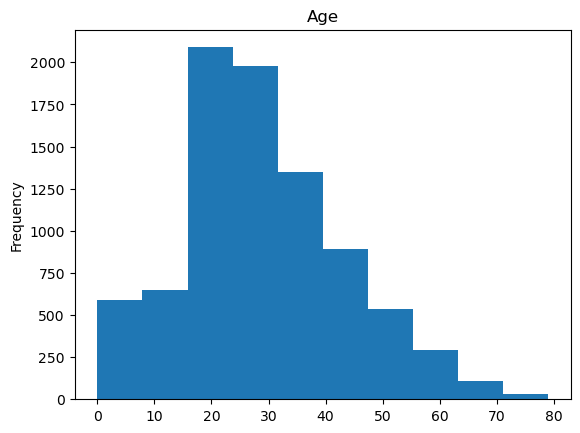

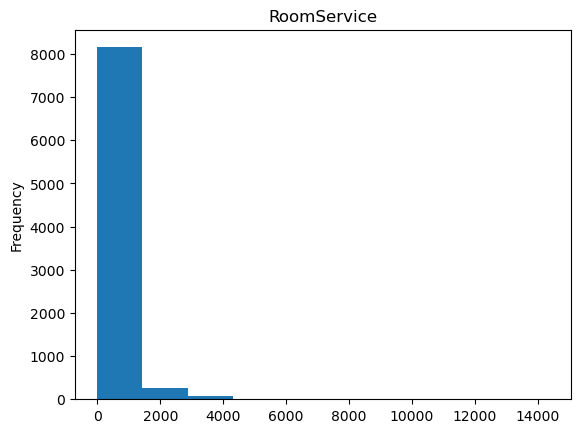

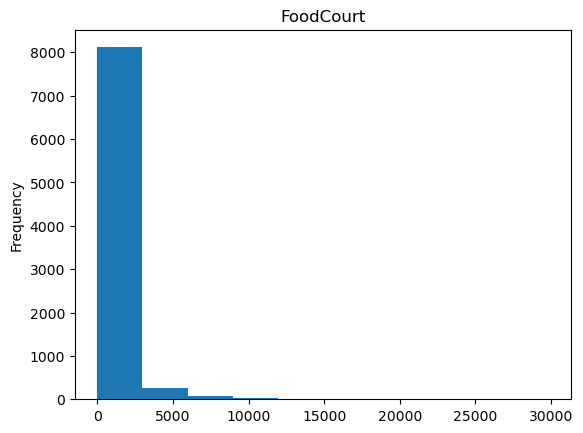

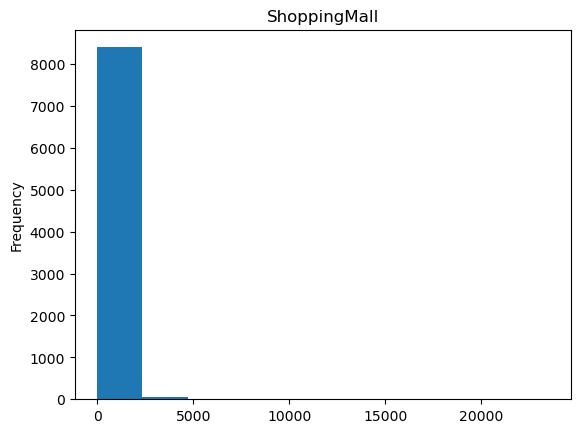

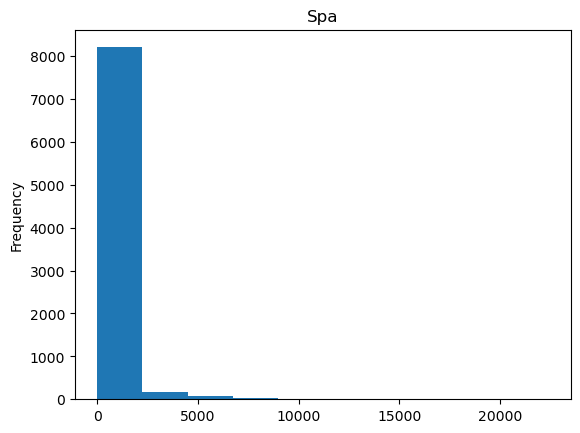

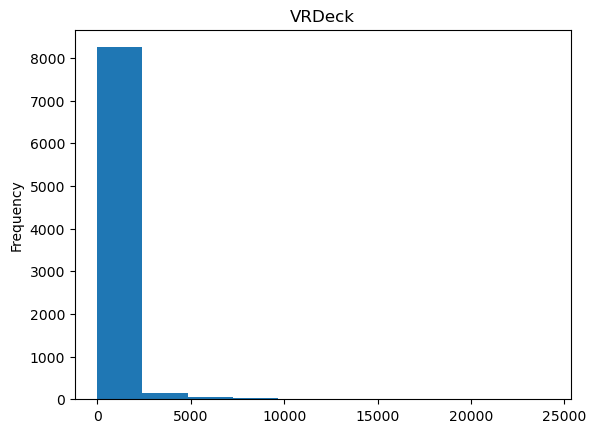

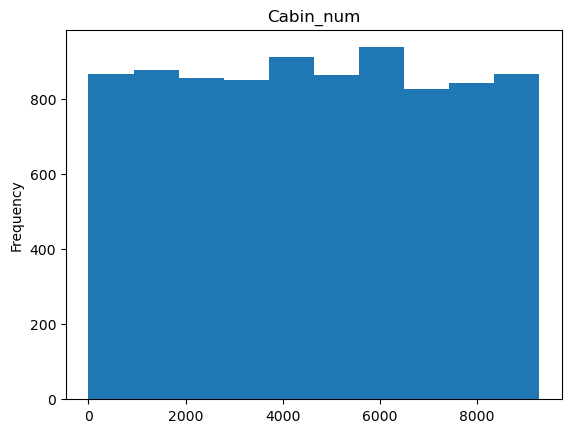

In [16]:
for col_name in num_data.columns:
    plt.figure()
    num_data[col_name].plot(kind='hist', title=col_name)
    plt.show()

# Feature engineering
Now I'll make the dataset with the features that I think will be most useful to train my model, and remove NaN values. The features that I'll be using are:
'CryoSleep', 'VIP', 'Deck', 'Side', 'Age', 'Transported'

In [17]:
# Making dataframe with the selected columns
train_data_clean = train_data[['CryoSleep', 'VIP', 'Deck', 'Side', 'Age', 'Transported']]
test_data_clean = test_data[['CryoSleep', 'VIP', 'Deck', 'Side', 'Age']]
train_data_clean

,CryoSleep,VIP,Deck,Side,Age,Transported
0,False,False,B,P,39.0,False
1,False,False,F,S,24.0,True
2,False,True,A,S,58.0,False
3,False,False,A,S,33.0,False
4,False,False,F,S,16.0,True
...,...,...,...,...,...,...
8688,False,True,A,P,41.0,False
8689,True,False,G,S,18.0,False
8690,False,False,G,S,26.0,True
8691,False,False,E,S,32.0,False


In [18]:
test_data_clean

,CryoSleep,VIP,Deck,Side,Age
0,True,False,G,S,27.0
1,False,False,F,S,19.0
2,True,False,C,S,31.0
3,False,False,C,S,38.0
4,False,False,F,S,20.0
...,...,...,...,...,...
4272,True,False,G,S,34.0
4273,False,False,NaN,NaN,42.0
4274,True,False,D,P,NaN
4275,False,False,D,P,NaN


Now, I'll create a pipeline to handle both NaN values and transform categorical values in numerical

In [19]:
train_data_clean.isna().sum()

CryoSleep      217
VIP            203
Deck           199
Side           199
Age            179
Transported      0
dtype: int64

Preprocessing train_data

In [20]:
# Define the columns for numerical and categorical features
numeric_features = train_data_clean.select_dtypes(include=['number']).columns
categorical_features = train_data_clean.select_dtypes(include=['object']).columns

# Create a preprocessing pipeline
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

# Specifying which columns require which transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['Age']),
        ('cat', categorical_transformer, ['CryoSleep', 'VIP', 'Deck', 'Side'])
    ]
)

# Fit and transform the data
train_preprocessed = preprocessor.fit_transform(train_data_clean)

# Get transformed categorical feature names after one-hot encoding
onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = onehot_encoder.get_feature_names_out(input_features=categorical_features)

# Fit and transform the data
train_preprocessed = preprocessor.fit_transform(train_data_clean)
train_preprocessed = pd.DataFrame(train_preprocessed, columns=list(numeric_features) + list(categorical_feature_names))

# Add the 'Transported' column to the preprocessed DataFrame
train_preprocessed['Transported'] = train_data_clean['Transported']

print("Original DataFrame:")
print(train_data_clean)

print("\nDataFrame after preprocessing:")
print(train_preprocessed)

Original DataFrame:
     CryoSleep    VIP Deck Side   Age  Transported
0        False  False    B    P  39.0        False
1        False  False    F    S  24.0         True
2        False   True    A    S  58.0        False
3        False  False    A    S  33.0        False
4        False  False    F    S  16.0         True
...        ...    ...  ...  ...   ...          ...
8688     False   True    A    P  41.0        False
8689      True  False    G    S  18.0        False
8690     False  False    G    S  26.0         True
8691     False  False    E    S  32.0        False
8692     False  False    E    S  44.0         True

[8693 rows x 6 columns]

DataFrame after preprocessing:
       Age  CryoSleep_False  CryoSleep_True  VIP_False  VIP_True  Deck_A  \
0     39.0              1.0             0.0        1.0       0.0     0.0   
1     24.0              1.0             0.0        1.0       0.0     0.0   
2     58.0              1.0             0.0        0.0       1.0     1.0   
3     3

Preprocessing test_data

In [21]:
# Define the columns for numerical and categorical features
numeric_features = test_data_clean.select_dtypes(include=['number']).columns
categorical_features = test_data_clean.select_dtypes(include=['object']).columns

# Create a preprocessing pipeline
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

# Specifying which columns require which transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['Age']),
        ('cat', categorical_transformer, ['CryoSleep', 'VIP', 'Deck', 'Side'])
    ]
)

# Fit and transform the data
test_preprocessed = preprocessor.fit_transform(test_data_clean)

# Get transformed categorical feature names after one-hot encoding
onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = onehot_encoder.get_feature_names_out(input_features=categorical_features)

# Fit and transform the data
test_preprocessed = preprocessor.fit_transform(test_data_clean)
test_preprocessed = pd.DataFrame(test_preprocessed, columns=list(numeric_features) + list(categorical_feature_names))

print("Original DataFrame:")
print(test_data_clean)

print("\nDataFrame after preprocessing:")
print(test_preprocessed)

Original DataFrame:
     CryoSleep    VIP Deck Side   Age
0         True  False    G    S  27.0
1        False  False    F    S  19.0
2         True  False    C    S  31.0
3        False  False    C    S  38.0
4        False  False    F    S  20.0
...        ...    ...  ...  ...   ...
4272      True  False    G    S  34.0
4273     False  False  NaN  NaN  42.0
4274      True  False    D    P   NaN
4275     False  False    D    P   NaN
4276      True  False    G    S  43.0

[4277 rows x 5 columns]

DataFrame after preprocessing:
       Age  CryoSleep_False  CryoSleep_True  VIP_False  VIP_True  Deck_A  \
0     27.0              0.0             1.0        1.0       0.0     0.0   
1     19.0              1.0             0.0        1.0       0.0     0.0   
2     31.0              0.0             1.0        1.0       0.0     0.0   
3     38.0              1.0             0.0        1.0       0.0     0.0   
4     20.0              1.0             0.0        1.0       0.0     0.0   
...    ... 

In [22]:
train_preprocessed.isna().sum()

Age                0
CryoSleep_False    0
CryoSleep_True     0
VIP_False          0
VIP_True           0
Deck_A             0
Deck_B             0
Deck_C             0
Deck_D             0
Deck_E             0
Deck_F             0
Deck_G             0
Deck_T             0
Side_P             0
Side_S             0
Transported        0
dtype: int64

# Building models
Now, I'll make some models and test, trying to find the best results

In [23]:
# Separate features and target variable
X = train_preprocessed.drop("Transported", axis=1)
y = train_preprocessed["Transported"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiating the models
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)
svm_model = SVC(random_state=0)
svm_model.fit(X_train, y_train)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
xgb_model = XGBClassifier(random_state=0)
xgb_model.fit(X_train, y_train)

# Making predictions
rf_preds = rf_model.predict(X_test)
lr_preds = lr_model.predict(X_test)
svm_preds = svm_model.predict(X_test)
knn_preds = knn_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

# Evaluating the models
print(f'RandomForestClassifier accuracy: {accuracy_score(y_test, rf_preds)}')
print(f'LogisticRegression accuracy: {accuracy_score(y_test, lr_preds)}')
print(f'SVM accuracy: {accuracy_score(y_test, svm_preds)}')
print(f'KNN accuracy: {accuracy_score(y_test, knn_preds)}')
print(f'XGBClassifier accuracy: {accuracy_score(y_test, xgb_preds)}')

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier accuracy: 0.7113283496262219
LogisticRegression accuracy: 0.7228292121909143
SVM accuracy: 0.7418056354226567
KNN accuracy: 0.6975273145485912
XGBClassifier accuracy: 0.7285796434732605


Among the methods I ran, the Support Vector Machine (SVM) yielded better results.

In [24]:
# Splitting train_data into train and test
X_train = train_preprocessed.drop('Transported', axis=1)
X_test = test_preprocessed
y_train = train_preprocessed['Transported']

model = SVC(random_state=0)
model.fit(X_train, y_train)

# Making predictions
y_preds = model.predict(X_test)

# Making output file
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Transported': y_preds})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# Results
Among the algorithms that I've tried, SVM produced the best results, although I might be able to further tune it for even better performance.